# Домашнее задание 2. StarGAN

### Загрузка данных
В данном задании вам предстоит работать с CelebA 64x64 и генерировать новые лица с заданными аттрибутами

In [20]:
import fileinput
from typing import Tuple
from os.path import exists, join

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import wandb
import requests
from torch import Tensor
from torch.nn import functional as F
from torchvision import transforms, utils
from tqdm.auto import trange, tqdm

%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py"
if not exists("celeba.py"):
    with open("celeba.py", "wb") as f:
        f.write(requests.get(url).content)

for line in fileinput.input("celeba.py", inplace=True):
    if fileinput.filelineno() not in [45, 46]:
        print(line[:-1])
        continue
    if fileinput.filelineno() == 45:
        corrected_line = "                download_url = 'https://drive.google.com/file/d/17NNnHn1RyPPmb4iQqIGJ2XFulfwyW1Sh/view?usp=sharing'"
    else:
        corrected_line = "                gdown.download(download_url, download_path, quiet=False, fuzzy=True)"
    print(corrected_line)

url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt"
if not exists("list_attr_celeba.txt"):
    with open("list_attr_celeba.txt", "wb") as f:
        f.write(requests.get(url).content)


from celeba import CelebADataset

Загрузим человекочитаемые названия доменов

In [3]:
with open("list_attr_celeba.txt", "r") as f:
    attr_name = np.array(f.readline().split(" ")[:-1])
attr_name

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype='<U19')

In [4]:
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        t_normalize,
    ]
)

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

Главная проблема мультидоменной генерации на селебе - наличие большого количества "бесполезных" классов, например 'Arched_Eyebrows', 'Attractive' 'Bags_Under_Eyes итд. Чтобы сделать задачу чуть проще, в этой домашке мы предлагаем вам взять 10 аттрибутов и учить im2im только на них

In [5]:
from random import randint


class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        indices = [8, 9, 11, 15, 16, 20, 22, 28, 35, 39]
        image, target = super().__getitem__(idx)
        target = target["attributes"] == 1
        new_target = target[indices]
        if sum(new_target) == 0:
            rand_ind = randint(0, len(self) - 1)
            return self[rand_ind]
        return image, new_target

In [6]:
attr_name = attr_name[[8, 9, 11, 15, 16, 20, 22, 28, 35, 39]]

In [7]:
dataset = CelebaCustomDataset(transform=transform, attr_file_path="list_attr_celeba.txt", crop=True)
img, attr = dataset[0]
img.shape, attr

Downloading...
From: https://drive.google.com/uc?id=12agH1nWYcj7PAoErxQQgFdOAohgS9qE_
To: /Users/Egor.Spirin/HSE/HSE.gans/homework_2/data/celeba/img_align_celeba_crop.zip
100%|██████████| 3.55M/3.55M [00:03<00:00, 996kB/s] 


(torch.Size([3, 64, 64]),
 tensor([False, False,  True, False, False, False, False, False, False,  True]))

### Визуализация датасета

In [8]:
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis("off")

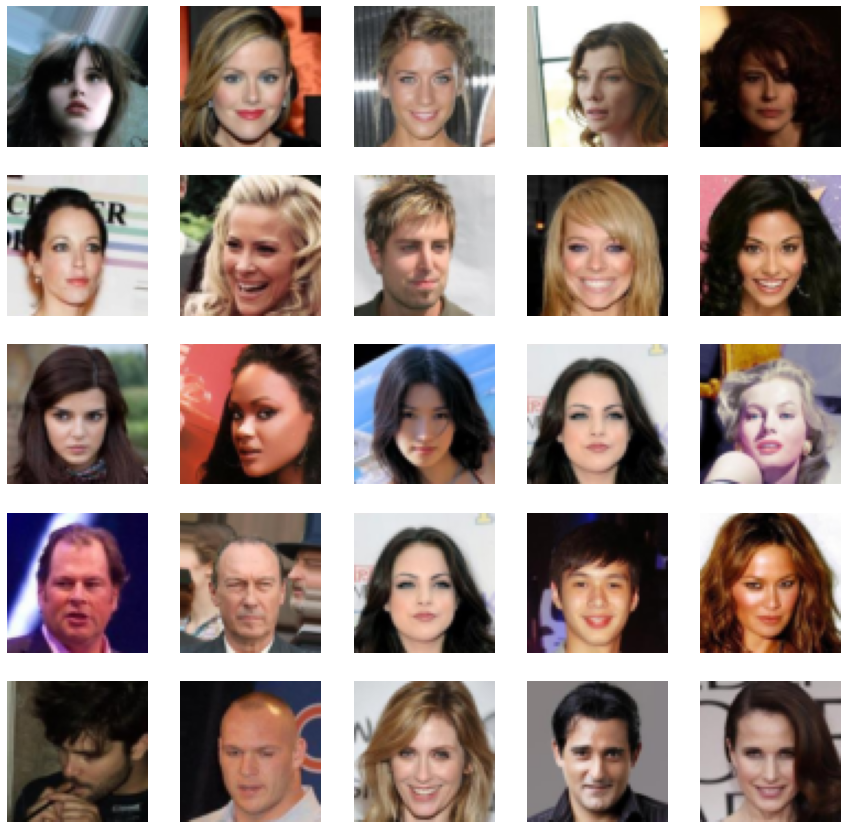

In [9]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img, attr = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (3/10 балла). Обучите low-res StarGanV1 на ограниченном подмножестве аттрибутов



В рамках данного задания предлагается реализовать и обучить [StarGAN v1](https://arxiv.org/pdf/1711.09020.pdf) для генерации лиц с заданными аттрибутами

<img src='https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/images/stargan_v1.png' width=600>

Вы можете добавлять любые дополнительные  параметры и использовать любые трюки для стабилизации/улучшения обучения на свое усмотрение. -->


In [10]:
class DownSampleBlock(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=2, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(hidden_dim, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.main(x)


class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(hidden_dim, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(hidden_dim, affine=True, track_running_stats=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return x + self.main(x)


class UpSampleBlock(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=2, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(hidden_dim, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.main(x)


class Generator(nn.Module):
    def __init__(self, hidden_dim: int = 32, c_dim: int = 10, n_residual: int = 2):
        super(Generator, self).__init__()

        # [3 + c; 64; 64] -> [h; 64; 64]
        layers = [
            nn.Conv2d(3 + c_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(hidden_dim, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        ]

        # Down-sampling layers
        # [h; 64; 64] -> [h; 32; 32] -> [h; 16; 16] -> [h; 8; 8]
        layers += [DownSampleBlock(hidden_dim) for _ in range(3)]

        # Residual layers
        layers += [ResidualBlock(hidden_dim) for _ in range(n_residual)]

        # Up-sampling layers
        # [h; 8; 8] -> [h; 16; 16] -> [h; 32; 32] -> [h; 64; 64]
        layers += [UpSampleBlock(hidden_dim) for _ in range(3)]

        layers += [nn.Conv2d(hidden_dim, 3, kernel_size=3, stride=1, padding=1, bias=False), nn.Tanh()]
        self.main = nn.Sequential(*layers)

    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        # [bs; c dim; 1; 1]
        c = c[..., None, None]
        # [bs; c dim; img h; img w]
        c = c.repeat(1, 1, x.shape[2], x.shape[2])
        # [bs; c dim + 3; img h; img w]
        x = torch.cat([x, c], dim=1)
        # [bs; 3; img h; img w]
        return self.main(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, hidden: int = 32, c_dim: int = 10):
        super().__init__()
        layers = [nn.Conv2d(3, hidden, kernel_size=3, stride=1, padding=1), nn.LeakyReLU()]
        for _ in range(6):
            # [h; 64; 64] -> [h; 32; 32] -> [h; 16; 16] -> [h; 8; 8] -> [h; 4; 4] -> [h; 2; 2] -> [h; 1; 1]
            layers += [nn.Conv2d(hidden, hidden, kernel_size=2, stride=2, padding=0), nn.LeakyReLU()]

        # [h]
        layers += [nn.Flatten(), nn.Linear(hidden, hidden), nn.LeakyReLU()]
        self.main = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden, 1)
        self.domain = nn.Linear(hidden, c_dim)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        # [bs; h]
        x = self.main(x)
        # [bs; 1]
        cls = self.classifier(x)
        # [bs; c dim]
        domains = self.domain(x)
        return cls, domains

Дальше идут несколько вспомогательных клеточек которые вы можете использовать, а можете не использовать

In [12]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
def make_grid_from_gen(gen, n_rows: int = 5):
    image, label = next(iter(dataloader))

    image, label = image.to(device), label.to(device).float()
    target_domain = label.flip(dims=[0])

    fake_image = gen(image, target_domain)[: n_rows * n_rows]

    return utils.make_grid(fake_image, nrow=n_rows, padding=5)

In [46]:
def gradient_penalty(cls, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones_like(cls)
    dydx = torch.autograd.grad(
        outputs=cls, inputs=x, grad_outputs=weight, retain_graph=True, create_graph=True, only_inputs=True
    )[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm - 1) ** 2)


def train(
    n_epochs: int = 10, lambda_domains: float = 10, lambda_gp: float = 10, lambda_rec: float = 10, n_critic: int = 5
):
    gen = Generator().to(device)
    disc = Discriminator().to(device)

    g_optim = torch.optim.AdamW(gen.parameters(), lr=1e-3)
    d_optim = torch.optim.AdamW(disc.parameters(), lr=1e-3)

    run = wandb.init(project="stargan-homework")

    for e in trange(n_epochs, desc="Epochs"):
        dataloader_pbar = tqdm(enumerate(dataloader), "Training", leave=False, total=len(dataloader))
        postfix = {}
        for i, (b_images, b_domains) in dataloader_pbar:
            b_images, b_domains = b_images.to(device), b_domains.to(device).float()
            b_random_domains = torch.randn(b_domains.shape, dtype=torch.float) > 0
            b_random_domains = b_random_domains.to(device).float()

            # Discriminator step
            cls, domains = disc(b_images)
            d_loss_real = F.cross_entropy(cls, torch.zeros_like(cls))
            d_loss_domains = F.binary_cross_entropy_with_logits(domains, b_domains)

            with torch.no_grad():
                x_fake = gen(b_images, b_random_domains).detach()
            cls, _ = disc(x_fake)
            d_loss_fake = F.cross_entropy(cls, torch.ones_like(cls))

            # Compute loss for gradient penalty
            alpha = torch.rand(b_images.shape[0], 1, 1, 1).to(device)
            x_hat = (alpha * b_images.data + (1 - alpha) * x_fake.data).requires_grad_(True)
            cls, _ = disc(x_hat)
            d_loss_gp = gradient_penalty(cls, x_hat)

            d_loss = d_loss_real + d_loss_fake + lambda_domains * d_loss_domains + lambda_gp * d_loss_gp

            d_optim.zero_grad()
            d_loss.backward()
            d_optim.step()

            run.log({"discriminator_loss": d_loss.item()})
            postfix["d loss"] = d_loss.item()

            # Generator step
            if (i + 1) % n_critic == 0:
                x_fake = gen(b_images, b_random_domains)
                cls, domains = disc(x_fake)
                g_loss_real = F.cross_entropy(cls, torch.zeros_like(cls))
                g_loss_domains = F.binary_cross_entropy_with_logits(domains, b_random_domains)

                x_recon = gen(x_fake, b_domains)
                g_loss_recon = F.l1_loss(x_recon, b_images)

                g_loss = g_loss_real + lambda_domains * g_loss_domains + lambda_rec * g_loss_recon

                g_optim.zero_grad()
                g_loss.backward()
                g_optim.step()

                run.log({"generator_loss": g_loss.item()})
                postfix["g loss"] = g_loss.item()

            dataloader_pbar.set_postfix(postfix)

        dataloader_pbar.close()

        cur_images = make_grid_from_gen(gen, n_rows=5)
        cur_images = t_invnormalize(cur_images)
        run.log({"examples": wandb.Image(cur_images)})

        checkpoint = {"gen": gen.state_dict(), "disc": disc.state_dict()}
        torch.save(checkpoint, join(run.dir, f"epoch_{e}.ckpt"))

    run.finish()
    return gen, disc


def train_or_load(ckpt_file_path=None):
    if ckpt_file_path is not None:
        checkpoint = torch.load(ckpt_file_path, map_location=device)
        gen = Generator()
        gen.load_state_dict(checkpoint["gen"])
        disc = Discriminator()
        disc.load_state_dict(checkpoint["disc"])
    else:
        gen, disc = train()

    return gen, disc

In [47]:
gen, _ = train_or_load()

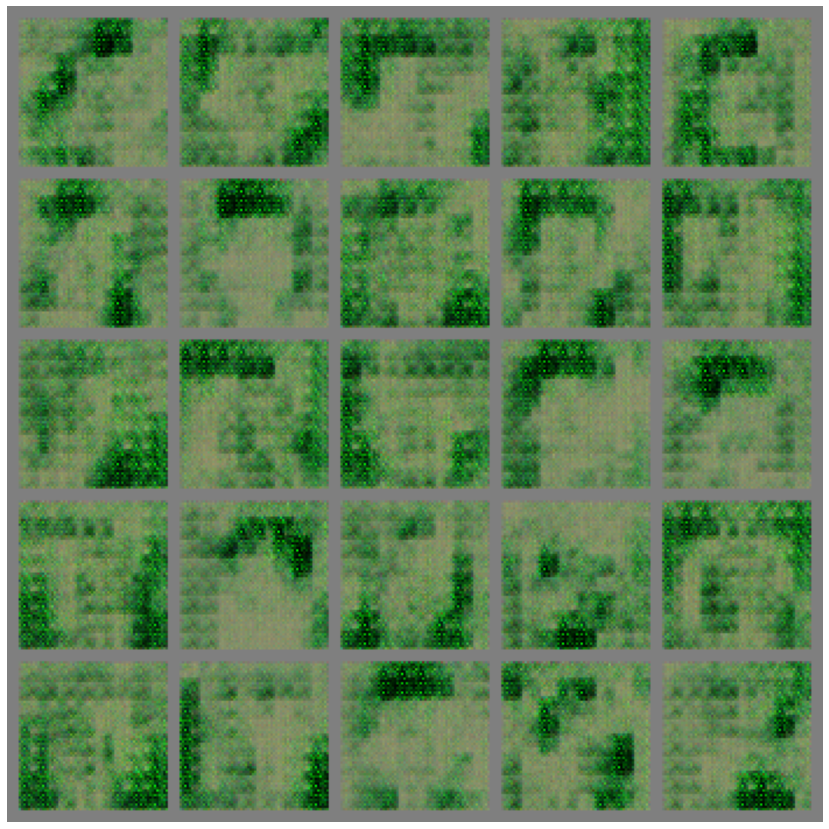

In [48]:
plt.figure(figsize=(15, 15))
grid = make_grid_from_gen(gen, 5)
plot_img(grid, t_invnormalize)

Target domain: 5_o_Clock_Shadow


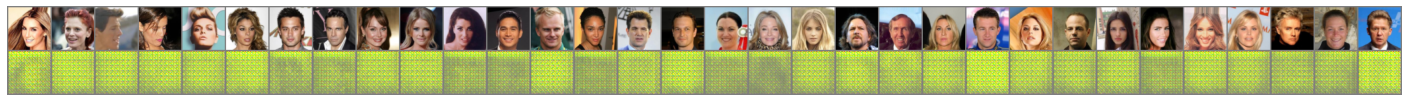

Target domain: Arched_Eyebrows


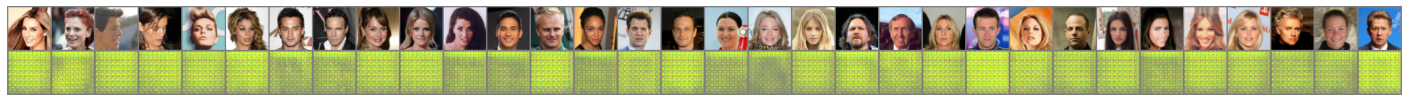

Target domain: Attractive


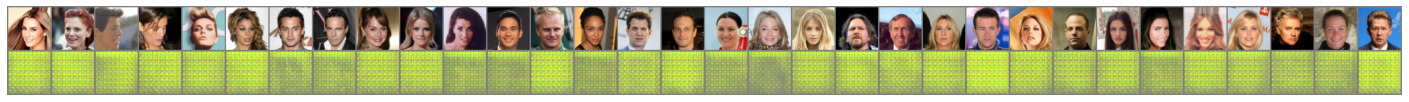

Target domain: Bags_Under_Eyes


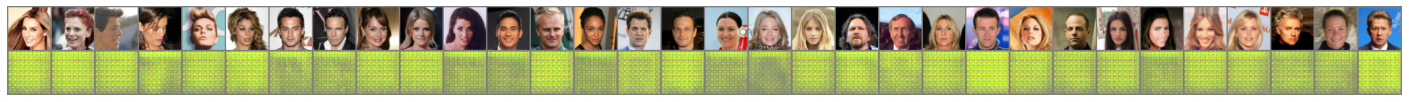

Target domain: Bald


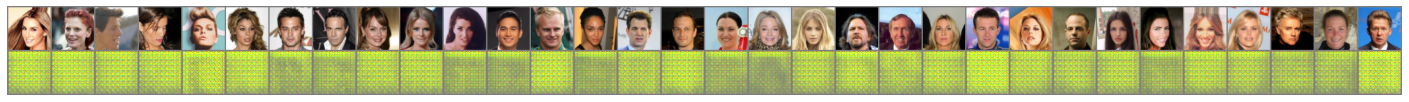

Target domain: Bangs


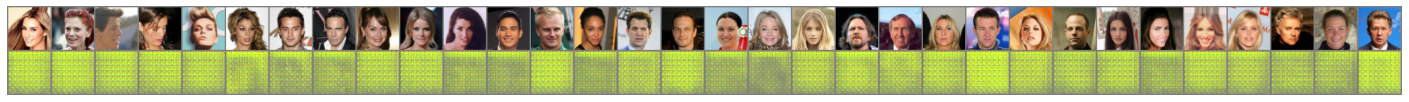

Target domain: Big_Lips


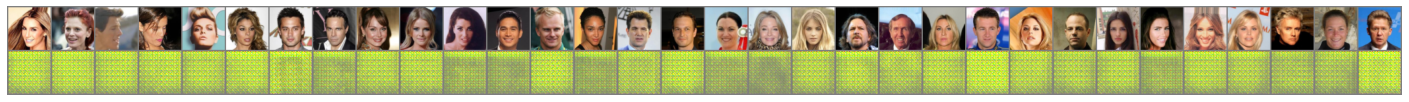

Target domain: Big_Nose


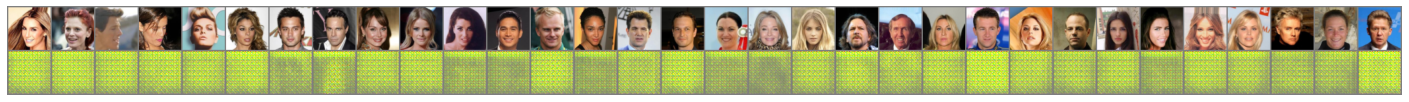

Target domain: Black_Hair


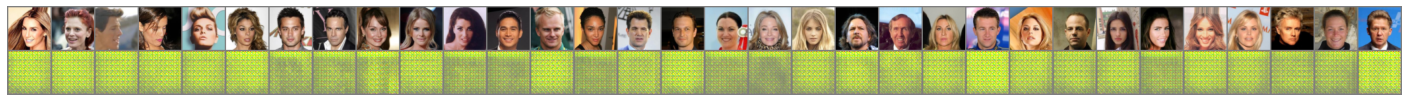

Target domain: Blond_Hair


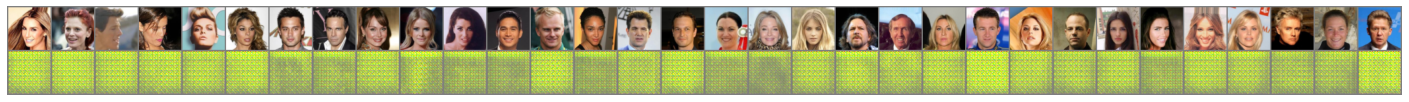

In [19]:
test_iters = 1
gen.eval()

iter_loader = iter(dataloader)

for i in trange(test_iters):
    x_real, y_real = next(iter_loader)
    y_real = y_real.float()

    x_real, y_real = x_real.to(device), y_real.to(device)

    for label_index in range(10):

        y_trg = y_real.clone()
        y_trg[label_index] = 1 - y_trg[label_index]  # reverse

        print(f"Target domain: {attr_name[label_index]}")

        with torch.no_grad():
            x_fake = gen(x_real, y_trg)

        plt.figure(figsize=(25, 15))
        x_show = (
            utils.make_grid(torch.cat([x_real, x_fake], dim=0), nrow=x_fake.shape[0], normalize=False).detach().cpu()
        )
        plot_img(x_show, t_invnormalize)
        plt.show()

Во время обучения вы можете считать FID вашей модели, но для автопроверки мы решили использовать LPIPS — [Learned Perceptual Image Patch Similarity](https://arxiv.org/abs/1801.03924) как финальную метрику качества. 

Точную цифру для получения баллов за задание мы сообщим позже

In [ ]:
# !pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

from lpips_pytorch import LPIPS

lpips = LPIPS().to(device)


def evaluate_model(dataloader, generator):
    values = []
    for x_real, label in tqdm(dataloader):
        x_real, label = x_real.to(device), label.to(device).float()
        target_domain = label.flip(dims=[0])

        with torch.no_grad():
            x_fake = generator(x_real, target_domain)

        values.append(lpips(x_fake, x_real).squeeze().item())
    return np.mean(values)


evaluate_model(dataloader, gen)

### Задача 2 (5/10 баллов). Обучите low-res StarGanV2 на ограниченном подмножестве аттрибутов

В рамках второго задания предлагается реализовать и обучить [StarGAN v2](https://arxiv.org/abs/1912.01865)

<img src='https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/images/stargan_v2.png' width=600>

Вы можете добавлять любые дополнительные  параметры на свое усмотрение.


In [ ]:
class Generator(nn.Module):
    def __init__(self, style_dim: int = 128, hidden_dim: int = 32, depth: int = 4):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, x, s=None, y=None):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim: int = 32, depth: int = 4):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, x: Tensor, y: Tensor):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
class StyleEncoder(nn.Module):
    def __init__(self, style_dim: int = 64, hidden_dim: int = 32, depth: int = 4):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, x: Tensor, y: Tensor):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim: int = 16, style_dim: int = 64):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, z: Tensor, y: Tensor):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
### BEGIN SOLUTION

style_enc = StyleEncoder().to(device)
mapping = MappingNetwork().to(device)
gen = Generator().to(device)
disc = Discriminator().to(device)

g_optim = None  # YOUR CODE
d_optim = None  # YOUR CODE
s_optim = None  # YOUR CODE
m_optim = None  # YOUR CODE

### END SOLUTION

In [ ]:
def train_models(ckpt_file_path):
    ### BEGIN SOLUTION
    checkpoint = torch.load(ckpt_file_path, map_location=torch.device("cpu"))
    generator = Generator()
    generator.load_state_dict(checkpoint["generator"])
    style_encoder = StyleEncoder()
    style_encoder.load_state_dict(checkpoint["style_encoder"])
    ### END SOLUTION
    return generator, style_encoder

In [ ]:
def evaluate_model_by_reference(dataloader, generator, style_encoder, latent_dim):
    values = []
    for x_real, label in tqdm(dataloader):
        x_real, label = x_real.to(device), label.to(device).float()
        x_ref = x_real.flip(dims=[0])
        target_domain = label.flip(dims=[0])

        with torch.no_grad():
            s_trg = style_encoder(x_ref, target_domain)
            x_fake = generator(x_real, s_trg)

        values.append(lpips(x_fake, x_real).squeeze().item())
    return np.mean(values)


evaluate_model(dataloader, gen)

### Задача 3 (2/10 балла). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **1+ балл**
1. Посмотрите получается ли у вас интерполяция в латентном пространстве
2. Покажите на каких доменах ваша модель работает хорошо, на каких не очень.
3. Попробуйте взять внешнюю картинку (не из селебы) и повторить результат.
4. Покажите самый смешной результат мультидоменной перекраски который у вас получался

* Текстовое ревью решения и предложения возможных улучшений - **1+ балл**
1. Опишите как вы решали задачу, какие методы описанные в статье вы использовали. Какие методы из других статей вы пробовали применять, что дало наибольший прирост в качестве?
2. Что бы вы предложили использовать еще, какие возможные улучшения здесь бы еще помогли получить бОльшее качество?


За хороший текст/результаты в этой задаче и за хорошее качество обученных моделей мы можем дать дополнительные баллы которые можно будет прибавить к другим домашкам :)

Эта задача выполняется отдельно и загружается в виде PDF в Anytask